In [1]:
from tqdm import tqdm
from glob import glob
from matplotlib.colors import ListedColormap
from PixelClassification.utils.preprocess_data import extract_data, split_train_val, get_data_properties
from PixelClassification.utils.visualize import visualize_many_images, visualize
from PixelClassification.utils.create_dicts import create_dataset_dict, create_model_dict, create_configs, create_test_configs_dict
from PixelClassification.train import begin_training
from PixelClassification.test import begin_evaluating
import tifffile, numpy as np, os, json, torch
%matplotlib inline

/home/manan/.local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Download data

>The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`, using `extract_data` function. 
Next, the `train` directories are split into `train` and `val` using `split_train_val`.

In [2]:
data_dir = '../../data'
project_name = 'dsb-2018'

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/dsb-2018.zip',
    data_dir = data_dir,
    project_name = project_name)

Zip file was downloaded and extracted before!


In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.15)

Train-Val-Test Images/Masks copied to ../../data/dsb-2018


### Calculate the `minimum object size` from the training labels

>In the next cell, we will calculate the `min_object_size` from the available train label masks

In [5]:
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                         mode='2d')

min_object_size = int(data_properties_dir['min_object_size'])

100%|█████████████████████████████████████████| 447/447 [00:16<00:00, 26.44it/s]

Minimum object size of the `dsb-2018` dataset is equal to 21.


<div class="alert alert-block alert-info"> <b>Any ideas on how one can use the `min_object_size` parameter for the purpose of segmentation?</b>

### Visualize images and their corresponding ground truth instance masks and semantic masks 

>Some of these images, their instance masks and the semantic masks are visualized.  
The instance masks are colored with a glasbey-style color map stored in `new_cmap`.

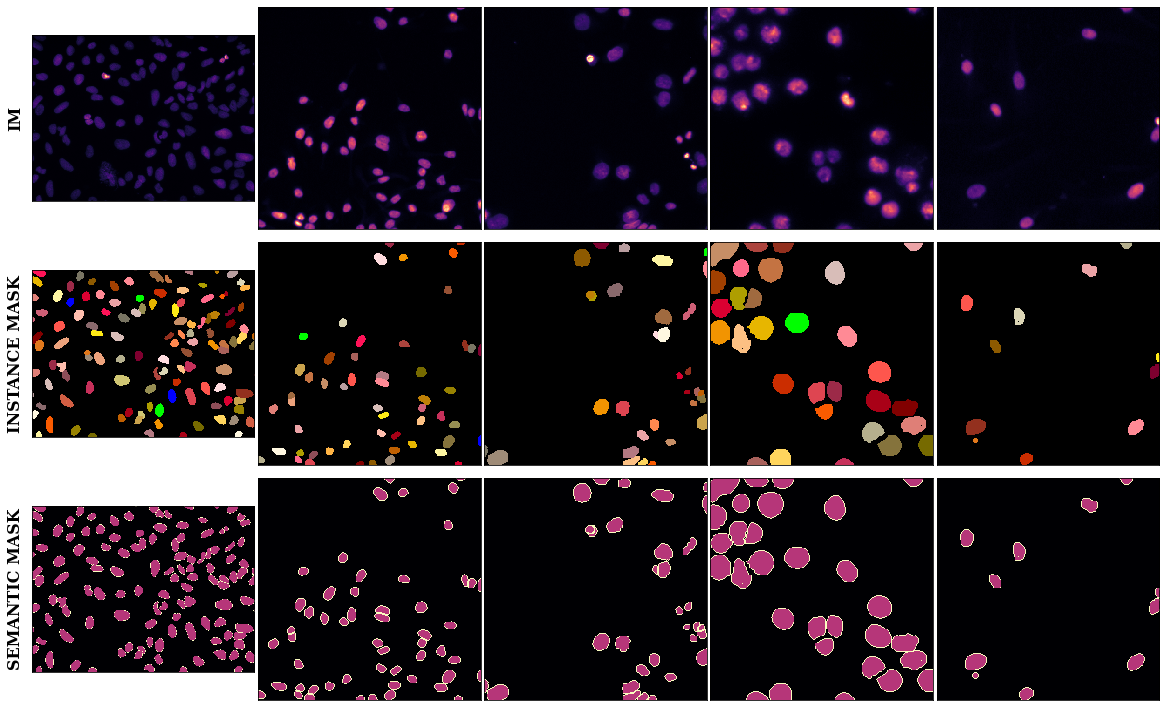

In [6]:
new_cmap = np.load('../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_images(data_dir=data_dir, project_name=project_name, train_val_dir='val', n_images=5, new_cmp=new_cmap)

<div class="alert alert-block alert-info"> <b>Are the relative populations of pixels per class the same? Can you quantify this by looping over the training instance masks? </b> <br>
In case one class is more dominant than the other (i..e class imbalance), how can we counteract this during the training? </div>

### Specify training dataset-related parameters

>We create a `train_dataset_dict` dictionary using the crops extracted from the train images and masks 

In [7]:
train_dataset_dict = create_dataset_dict(data_dir = data_dir, 
                                         project_name = project_name,  
                                         size = len(os.listdir(os.path.join(data_dir, project_name, 'train', 'images'))), 
                                         batch_size = 16, 
                                         type = 'train')

`train_dataset_dict` dictionary successfully created with: 
 -- train images accessed from ../../data/dsb-2018/train/images, 
 -- number of images per epoch equal to 3000, 
 -- batch size set at 16, 


### Specify validation dataset-related parameters

>We create a `val_dataset_dict` dictionary using the crops extracted from the validation images and masks 

In [8]:
val_dataset_dict = create_dataset_dict(data_dir = data_dir, 
                                       project_name = project_name, 
                                       size = len(os.listdir(os.path.join(data_dir, project_name, 'val', 'images'))), 
                                       batch_size = 16, 
                                       type ='val')

`val_dataset_dict` dictionary successfully created with: 
 -- val images accessed from ../../data/dsb-2018/val/images, 
 -- number of images per epoch equal to 400, 
 -- batch size set at 16, 


### Specify model-related parameters

>In the cell after this one, a `model_dataset_dict` dictionary is created.  
Number of classes is set to `3` by default, where the first class is background, second class is foreground (interior of a cell or nucleus) and third class is the membrane.

In [9]:
model_dict = create_model_dict()

`model_dict` dictionary successfully created with: 
 -- num of classes equal to 3, 
 -- name equal to unet


<div class="alert alert-block alert-info"> <b>Which other parameters can we set while initializing the model? </b>  <br>
For example, what is the default depth of the `U-Net` model? 
What would the benefit/disadvantage of increasing the `depth` of the model? 
Which other parameters are of interest? 

</div> 

### Specify the duration of training by setting `n_epochs`

>In the cell after this one, a `configs` dictionary is created.  
The model weights are saved by default at `experiment/dsb-2018-demo`

In [10]:
n_epochs = 20

In [11]:
configs = create_configs(save_dir = os.path.join('experiment', project_name+'-'+'demo'), 
                         n_epochs=n_epochs,
                         resume_path=None,
                         )

`configs` dictionary successfully created with: 
 -- n_epochs equal to 5, 
 -- save_dir equal to experiment/dsb-2018-demo, 


### Begin training!

>We input the dictionaries created above to the `begin_training` function.  

In [ ]:
%matplotlib Agg
begin_training(train_dataset_dict, val_dataset_dict, model_dict, configs)

<div class="alert alert-block alert-info"> <b> How is the best model state decided? </b><br>  
    What is the <i>ap</i> value, which is printed at the end of each epoch?</div>


<div class="alert alert-block alert-info"> <b> Investigate whether the loss curve (<i>examples/DL4MIA/experiment/dsb-2018-demo/loss.png</i>) has flattened out.</b>  <br>
Do you think <u>longer</u> training benefit?  </div>  


### Infer using your model weights 

> The training phase is over for now.  
Let's use the model trained by you above for $20$ epochs to infer on unseen images, next.

In [ ]:
checkpoint_path = os.path.join('experiment', project_name+'-'+'demo', 'best_iou_model.pth')

### Specify where results should be saved during  inference

>We set the location where the predictions of the test images are saved with `save_dir`.  
In the cell after this one, a `test_configs` dictionary is created.

In [ ]:
save_dir = './inference/' + project_name

In [ ]:
test_configs = create_test_configs_dict(data_dir = os.path.join(data_dir, project_name),
                                        checkpoint_path = checkpoint_path,
                                        min_object_size = min_object_size, 
                                        save_dir = save_dir,
                                        )

<div class="alert alert-block alert-info">
    Investigate the <b>test_configs</b> dictionary
</div>    

In [ ]:
test_configs

### Evaluate on unseen test data

>The `test_configs` dictionary created above, is input to the `begin_evaluating` function.

In [ ]:
%matplotlib inline
result = begin_evaluating(test_configs)

In [ ]:
%matplotlib inline
prediction_file_names = sorted(glob(os.path.join(save_dir,'predictions','*.tif')))
ground_truth_file_names = sorted(glob(os.path.join(save_dir,'ground-truth','*.tif')))
seed_file_names = sorted(glob(os.path.join(save_dir,'seeds','*.tif')))
image_file_names = sorted(glob(os.path.join(data_dir, project_name, 'test', 'images','*.tif')))

### Visualize some results on unseen test data

>Change value of `index` to see predictions on different unseen, test images.

In [ ]:
index = 0
print("Image filename is {} and index is {}".format(os.path.basename(image_file_names[index]), index))
prediction = tifffile.imread(prediction_file_names[index])
image = tifffile.imread(image_file_names[index])
seed = tifffile.imread(seed_file_names[index])
if len(ground_truth_file_names) > 0:
    ground_truth = tifffile.imread(ground_truth_file_names[index])
    visualize(image = image, prediction = prediction, ground_truth = ground_truth, seed = seed, new_cmp = new_cmap)
else:
    visualize(image = image, prediction = prediction, ground_truth = None, seed = seed, new_cmp = new_cmap)

<div class="alert alert-block alert-info">
Look at some predictions by changing the <i>index</i> variable in the cell above. <br> 
What errors do you commonly see in the predictions?
</div>    